In [1]:
!pip install --upgrade kagglehub[pandas-datasets,hf-datasets]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.11
    Uninstalling kagglehub-0.3.11:
      Successfully uninstalled kagglehub-0.3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; plat

In [2]:
!apt-get install git -y

!git clone https://github.com/miriam-16/aml_1_aerial_imagery.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 122 not upgraded.
Cloning into 'aml_1_aerial_imagery'...
remote: Enumerating objects: 21535, done.
remote: Counting objects: 100% (21535/21535), done.
remote: Compressing objects: 100% (3105/3105), done.
remote: Total 21535 (delta 18426), reused 21531 (delta 18422), pack-reused 0 (from 0)
Receiving objects: 100% (21535/21535), 12.63 MiB | 43.10 MiB/s, done.
Resolving deltas: 100% (18426/18426), done.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [43]:
path = "/kaggle/working/aml_1_aerial_imagery/dataset"
import pandas as pd

labels_df = pd.read_csv(path+'/train.csv')  # Adjust filename
print(labels_df.head())


                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


In [44]:
print(labels_df.shape)
labels_df[labels_df.duplicated(keep=False)]


(17500, 2)


,id,has_cactus


In [7]:
labels_df['has_cactus'].value_counts()

has_cactus
1    13136
0     4364
Name: count, dtype: int64

In [45]:
import torch
torch.manual_seed(0)

from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

class pytorch_data(Dataset):
    
    def __init__(self, data_dir, transform, data_type="train"):
        # Get Image File Names
        cdm_data = os.path.join(data_dir, data_type)
        file_names = os.listdir(cdm_data)

        all_image_paths = [os.path.join(cdm_data, f) for f in file_names if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        print(f"Found {len(all_image_paths)} images in directory.")
        print(f"Sample filenames: {all_image_paths[:1]}")

        # Get Labels
        labels_data = os.path.join("/kaggle/working/aml_1_aerial_imagery/dataset/", "train.csv")
        labels_df = pd.read_csv(labels_data)

        # Normalize index: remove extensions if present
        labels_df['id'] = labels_df['id'].apply(lambda x: os.path.splitext(str(x))[0])
        labels_df.set_index("id", inplace=True)

        print(f"Labels dataframe length: {len(labels_df)}")

        # Extract only valid images (that have a label)
        valid_filenames = []
        labels = []

        for f in all_image_paths:
            filename = os.path.basename(f)  # get only file name
            image_id = os.path.splitext(filename)[0]  # remove extension

            if image_id in labels_df.index:
                valid_filenames.append(f)
                labels.append(labels_df.loc[image_id].values[0])
            else:
                print(f"Warning: image '{filename}' has no matching label in train.csv")

        self.full_filenames = valid_filenames
        self.labels = labels
        self.transform = transform

        print(f"Valid image-label pairs: {len(self.full_filenames)}")
        print(f"First few labels: {self.labels[:5]}")
      
    def __len__(self):
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        if idx >= len(self.full_filenames):
            raise IndexError(f"Index {idx} out of bounds for dataset of length {len(self.full_filenames)}")

        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [46]:
# define transformation that converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((32,32))])


In [47]:
# Define an object of the custom dataset for the train folder.
data_dir = path+'/train/'
img_dataset = pytorch_data(data_dir, data_transformer, "train")

Found 17500 images in directory.
Sample filenames: ['/kaggle/working/aml_1_aerial_imagery/dataset/train/train/d61b9446a08b2e46d03ee74ba2642239.jpg']
Labels dataframe length: 17500
Valid image-label pairs: 17500
First few labels: [1, 1, 1, 1, 1]


In [48]:
# define transformation that converts a PIL image into PyTorch tensors
data_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

In [49]:
# Test a sample
img, label = img_dataset[10]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 32, 32]) tensor(0.0471) tensor(0.7176)


In [50]:
# Aumentiamo le immagini della classe 0
from torchvision.transforms import RandomRotation, ToTensor, Resize
from tqdm import tqdm

# Trasformazione per augmentare
augment_transform = transforms.Compose([
    RandomRotation(degrees=10),
    Resize((32, 32)),
    ToTensor()
])

# Trova solo immagini con etichetta 0
images_class0 = [i for i in range(len(img_dataset)) if img_dataset.labels[i] == 0]

# Duplichiamo queste immagini con trasformazione
augmented_images = []
augmented_labels = []

for idx in tqdm(images_class0):
    img_path = img_dataset.full_filenames[idx]
    img = Image.open(img_path)
    augmented_img = augment_transform(img)
    augmented_images.append(augmented_img)
    augmented_labels.append(0)

# Stack immagini originali
original_images = [img_dataset[i][0] for i in range(len(img_dataset))]
original_labels = [img_dataset[i][1] for i in range(len(img_dataset))]

# Combina immagini originali + augmentate
all_images = torch.stack(original_images + augmented_images)
all_labels = torch.tensor(original_labels + augmented_labels)

# Nuovo Dataset custom con dati augmentati
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Sostituisci img_dataset con quello nuovo
img_dataset = AugmentedDataset(all_images, all_labels)

100%|██████████| 4364/4364 [00:01<00:00, 2246.98it/s]


In [51]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Estrai le etichette in modo sicuro
labels = img_dataset.labels  # NON usare img_dataset[i][1]

# Crea una lista di tutti gli indici
all_indices = list(range(len(img_dataset)))

# Split stratificato: Train (70%) e Temp (30%)
train_idx, temp_idx = train_test_split(
    all_indices, test_size=0.3, stratify=labels, random_state=42
)

# Estrai le label corrispondenti agli indici temporanei per secondo split
temp_labels = [labels[i] for i in temp_idx]

# Split stratificato: Validation (15%) e Test (15%) da temp
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_labels, random_state=42
)

# Crea i subset PyTorch
train_ts = Subset(img_dataset, train_idx)
val_ts = Subset(img_dataset, val_idx)
test_ts = Subset(img_dataset, test_idx)

# Visualizzazione
print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))
print("test dataset size:", len(test_ts))

train dataset size: 15304
validation dataset size: 3280
test dataset size: 3280


# NEW MODEL: LOGISTIC REGRESSION

In [54]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))


Cost after iteration 0: 5.954573
Cost after iteration 100: 0.541984
Cost after iteration 200: 0.481981
Cost after iteration 300: 0.447249
Cost after iteration 400: 0.424166
Cost after iteration 500: 0.407546
Cost after iteration 600: 0.394933
Cost after iteration 700: 0.384991
Cost after iteration 800: 0.376920
Cost after iteration 900: 0.370212
Cost after iteration 1000: 0.364525
Cost after iteration 1100: 0.359623
Cost after iteration 1200: 0.355338
Cost after iteration 1300: 0.351546
Cost after iteration 1400: 0.348152


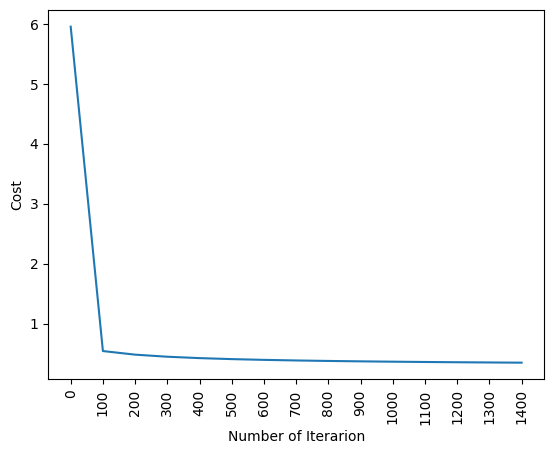

Test Accuracy: 83.48 %
Train Accuracy: 84.21 %


In [55]:
import numpy as np

def subset_to_numpy(subset):
    images = []
    labels = []
    for img, label in subset:
        images.append(img.numpy().flatten())  # flatten 3D tensor to 1D vector
        labels.append(label)
    X = np.array(images).T  # shape: (features, samples)
    Y = np.array(labels).reshape(1, -1)  # shape: (1, samples)
    return X, Y

# Convert datasets to NumPy
x_train, y_train = subset_to_numpy(train_ts)
x_test, y_test = subset_to_numpy(test_ts)

# Call your logistic regression function
logistic_regression(x_train, y_train, x_test, y_test, learning_rate=0.01, num_iterations=3500)


In [57]:
def grid_search_logistic_regression(x_train, y_train, x_val, y_val, learning_rates, iteration_counts):
    best_accuracy = 0
    best_params = {}
    
    for lr in learning_rates:
        for num_iter in iteration_counts:
            print(f"\nTraining with learning_rate={lr}, num_iterations={num_iter}")
            
            dimension = x_train.shape[0]
            w, b = initialize_weights_and_bias(dimension)
            parameters, gradients, _ = update(w, b, x_train, y_train, lr, num_iter)
            
            y_pred_val = predict(parameters["weight"], parameters["bias"], x_val)
            accuracy = 100 - np.mean(np.abs(y_pred_val - y_val)) * 100
            print(f"Validation Accuracy: {accuracy:.2f}%")
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    "learning_rate": lr,
                    "num_iterations": num_iter,
                    "weight": parameters["weight"],
                    "bias": parameters["bias"]
                }
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best validation accuracy: {best_accuracy:.2f}%")
    return best_params


In [ ]:
# Convert val set
x_val, y_val = subset_to_numpy(val_ts)

# Define search space
learning_rates = [0.1, 1, 10]
iteration_counts = [500, 1000, 1500]

# Run grid search
best = grid_search_logistic_regression(x_train, y_train, x_val, y_val, learning_rates, iteration_counts)


In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import torch

# Reuse conversion function
def dataset_to_numpy(dataset):
    X = []
    y = []
    for img, label in dataset:
        X.append(img.view(-1).numpy())  # Flatten image
        y.append(label)
    return np.array(X), np.array(y)

# Prepare data
X_train, y_train = dataset_to_numpy(train_ts)
X_val, y_val = dataset_to_numpy(val_ts)
X_test, y_test = dataset_to_numpy(test_ts)

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Combine train and val for tuning
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],               # Inverse regularization strength
    'solver': ['lbfgs'],                   # Recommended solver for binary problems
    'penalty': ['l2'],                     # Regularization type
    'max_iter': [1500, 3000]                # Ensure convergence
}

# Initialize and perform grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, verbose=1, scoring='accuracy')
grid_search.fit(X_combined, y_combined)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'C': 10, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'lbfgs'}


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Combine training and validation sets
X_train_final = np.concatenate((X_train, X_val))
y_train_final = np.concatenate((y_train, y_val))

# Retrain with best parameters
final_model = LogisticRegression(
    C=10,
    penalty='l2',
    solver='lbfgs',
    max_iter=1500
)
final_model.fit(X_train_final, y_train_final)

# Predict on test set
y_pred_test = final_model.predict(X_test)

# Evaluate
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"✅ Final Test Accuracy: {test_accuracy * 100:.2f}%\n")

# Optional: Detailed classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_test))


✅ Final Test Accuracy: 81.01%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.55      0.70      1309
           1       0.77      0.99      0.86      1971

    accuracy                           0.81      3280
   macro avg       0.86      0.77      0.78      3280
weighted avg       0.84      0.81      0.80      3280

